In [3]:
import pandas as pd
import os
from pathlib import Path
from typing import Union, List

def load_crypto_data(
    base_path: Union[str, Path],
    symbol: str = "BTCUSDT",
    year: str = "2022",
    freq: str = "1m"
) -> pd.DataFrame:
    """
    加載並合併特定交易對的所有每日CSV文件
    
    Args:
        base_path (str/Path): 數據文件的基礎路徑
        symbol (str): 交易對名稱，如 "BTCUSDT"
        year (str): 年份，如 "2022"
        freq (str): 頻率，如 "1m"
    
    Returns:
        pd.DataFrame: 合併後的DataFrame
    """
    # 確保base_path是Path對象
    base_path = Path(base_path)
    
    # 構建文件匹配模式
    pattern = f"{symbol}_{year}-*_{freq}.csv"
    
    # 獲取所有匹配的文件並排序
    csv_files = sorted(list(base_path.glob(pattern)))
    
    if not csv_files:
        raise ValueError(f"No files found matching pattern: {pattern}")
    
    # 讀取並合併所有CSV文件
    dfs = []
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            dfs.append(df)
        except Exception as e:
            print(f"Error reading file {file}: {e}")
    
    # 合併所有DataFrame
    if not dfs:
        raise ValueError("No data was successfully loaded")
    
    merged_df = pd.concat(dfs, ignore_index=True)
    
    # 確保時間列正確格式化
    merged_df['open_time'] = pd.to_datetime(merged_df['open_time'])
    merged_df['close_time'] = pd.to_datetime(merged_df['close_time'])
    
    # 按時間排序
    merged_df = merged_df.sort_values('open_time').reset_index(drop=True)
    
    # 檢查並移除重複數據
    merged_df = merged_df.drop_duplicates(subset=['open_time'], keep='first')
    
    return merged_df

def check_data_quality(df: pd.DataFrame) -> dict:
    """
    檢查合併後數據的質量
    
    Args:
        df (pd.DataFrame): 待檢查的DataFrame
    
    Returns:
        dict: 包含各種數據質量指標的字典
    """
    quality_report = {
        'total_rows': len(df),
        'date_range': (df['open_time'].min(), df['open_time'].max()),
        'missing_values': df.isnull().sum().to_dict(),
        'duplicate_times': len(df) - len(df['open_time'].unique()),
    }
    
    # 檢查時間間隔
    time_diffs = df['open_time'].diff().value_counts()
    quality_report['time_intervals'] = time_diffs
    
    return quality_report

# 使用示例


In [4]:
if __name__ == "__main__":
    # 假設數據路徑
    data_path = "/Users/mouyasushi/Desktop/quantDevops/Backtest_Performance/Alpha-Research/kline/binance/BTCUSDT/1m"
    
    # 加載數據
    btc_data = load_crypto_data(
        base_path=data_path,
        symbol="BTCUSDT",
        year="2024",
        freq="1m"
    )
    
    # 檢查數據質量
    quality_report = check_data_quality(btc_data)
    
    # 輸出基本信息
    print(f"Loaded data shape: {btc_data.shape}")
    print(f"Date range: {quality_report['date_range']}")
    print(f"Total rows: {quality_report['total_rows']}")

Loaded data shape: (488160, 12)
Date range: (Timestamp('2024-01-01 00:00:00'), Timestamp('2024-12-04 23:59:00'))
Total rows: 488160


In [5]:
import numpy as np

# Compute log return
btc_data['log_return'] = np.log(btc_data['close'] / btc_data['close'].shift(1))

# Drop a single column
btc_data = btc_data.drop('ignore', axis=1)

btc_data



,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,log_return
0,2024-01-01 00:00:00,42314.0,42335.8,42289.6,42331.9,289.641,2024-01-01 00:00:59.999,1.225616e+07,3310,175.211,7.414460e+06,NaN
1,2024-01-01 00:01:00,42331.9,42353.1,42331.8,42350.4,202.444,2024-01-01 00:01:59.999,8.572241e+06,1885,154.353,6.535805e+06,0.000437
2,2024-01-01 00:02:00,42350.4,42370.8,42349.6,42360.2,271.521,2024-01-01 00:02:59.999,1.150139e+07,2143,193.034,8.176843e+06,0.000231
3,2024-01-01 00:03:00,42360.1,42405.8,42360.1,42405.8,392.238,2024-01-01 00:03:59.999,1.662644e+07,3551,332.749,1.410472e+07,0.001076
4,2024-01-01 00:04:00,42405.7,42437.2,42405.7,42437.1,568.366,2024-01-01 00:04:59.999,2.411261e+07,4479,419.524,1.779786e+07,0.000738
...,...,...,...,...,...,...,...,...,...,...,...,...
488155,2024-12-04 23:55:00,98803.5,98835.0,98775.7,98786.1,70.970,2024-12-04 23:55:59.999,7.012476e+06,1567,35.110,3.469313e+06,-0.000176
488156,2024-12-04 23:56:00,98786.1,98792.9,98734.6,98770.7,151.892,2024-12-04 23:56:59.999,1.499998e+07,2414,51.604,5.096036e+06,-0.000156
488157,2024-12-04 23:57:00,98770.7,98778.0,98740.1,98769.9,73.575,2024-12-04 23:57:59.999,7.265887e+06,1396,19.852,1.960477e+06,-0.000008
488158,2024-12-04 23:58:00,98769.9,98769.9,98670.3,98670.3,161.254,2024-12-04 23:58:59.999,1.591837e+07,2367,27.760,2.740686e+06,-0.001009


In [6]:
btc_data.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'log_return'],
      dtype='object')

In [7]:
def calculate_maker_ratios(df):
    """
    Calculate VWAPs and maker ratios
    """
    # 1. Calculate taker sell volumes first
    df['taker_sell_base_volume'] = df['volume'] - df['taker_buy_base_asset_volume']
    df['taker_sell_quote_volume'] = df['quote_asset_volume'] - df['taker_buy_quote_asset_volume']
    
    # 2. Calculate maker volumes
    df['maker_buy_base_volume'] = df['taker_sell_base_volume']
    df['maker_sell_base_volume'] = df['taker_buy_base_asset_volume']
    df['maker_buy_quote_volume'] = df['taker_sell_quote_volume']
    df['maker_sell_quote_volume'] = df['taker_buy_quote_asset_volume']
    
    # 3. Calculate maker buy/sell ratios
    df['maker_base_ratio'] = df['maker_buy_base_volume'] / df['maker_sell_base_volume']
    df['taker_base_ratio'] = df['taker_buy_base_asset_volume'] / df['taker_sell_base_volume']

    
    return df


df = calculate_maker_ratios(btc_data)
df['taker_base_ratio']

0         1.531163
1         3.209603
2         2.459439
3         5.593454
4         2.818586
            ...   
488155    0.979085
488156    0.514558
488157    0.369525
488158    0.207949
488159    0.902514
Name: taker_base_ratio, Length: 488160, dtype: float64

In [8]:
df

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,log_return,taker_sell_base_volume,taker_sell_quote_volume,maker_buy_base_volume,maker_sell_base_volume,maker_buy_quote_volume,maker_sell_quote_volume,maker_base_ratio,taker_base_ratio
0,2024-01-01 00:00:00,42314.0,42335.8,42289.6,42331.9,289.641,2024-01-01 00:00:59.999,1.225616e+07,3310,175.211,7.414460e+06,NaN,114.430,4.841695e+06,114.430,175.211,4.841695e+06,7.414460e+06,0.653098,1.531163
1,2024-01-01 00:01:00,42331.9,42353.1,42331.8,42350.4,202.444,2024-01-01 00:01:59.999,8.572241e+06,1885,154.353,6.535805e+06,0.000437,48.091,2.036436e+06,48.091,154.353,2.036436e+06,6.535805e+06,0.311565,3.209603
2,2024-01-01 00:02:00,42350.4,42370.8,42349.6,42360.2,271.521,2024-01-01 00:02:59.999,1.150139e+07,2143,193.034,8.176843e+06,0.000231,78.487,3.324547e+06,78.487,193.034,3.324547e+06,8.176843e+06,0.406597,2.459439
3,2024-01-01 00:03:00,42360.1,42405.8,42360.1,42405.8,392.238,2024-01-01 00:03:59.999,1.662644e+07,3551,332.749,1.410472e+07,0.001076,59.489,2.521721e+06,59.489,332.749,2.521721e+06,1.410472e+07,0.178780,5.593454
4,2024-01-01 00:04:00,42405.7,42437.2,42405.7,42437.1,568.366,2024-01-01 00:04:59.999,2.411261e+07,4479,419.524,1.779786e+07,0.000738,148.842,6.314748e+06,148.842,419.524,6.314748e+06,1.779786e+07,0.354788,2.818586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488155,2024-12-04 23:55:00,98803.5,98835.0,98775.7,98786.1,70.970,2024-12-04 23:55:59.999,7.012476e+06,1567,35.110,3.469313e+06,-0.000176,35.860,3.543163e+06,35.860,35.110,3.543163e+06,3.469313e+06,1.021361,0.979085
488156,2024-12-04 23:56:00,98786.1,98792.9,98734.6,98770.7,151.892,2024-12-04 23:56:59.999,1.499998e+07,2414,51.604,5.096036e+06,-0.000156,100.288,9.903943e+06,100.288,51.604,9.903943e+06,5.096036e+06,1.943415,0.514558
488157,2024-12-04 23:57:00,98770.7,98778.0,98740.1,98769.9,73.575,2024-12-04 23:57:59.999,7.265887e+06,1396,19.852,1.960477e+06,-0.000008,53.723,5.305409e+06,53.723,19.852,5.305409e+06,1.960477e+06,2.706176,0.369525
488158,2024-12-04 23:58:00,98769.9,98769.9,98670.3,98670.3,161.254,2024-12-04 23:58:59.999,1.591837e+07,2367,27.760,2.740686e+06,-0.001009,133.494,1.317768e+07,133.494,27.760,1.317768e+07,2.740686e+06,4.808862,0.207949


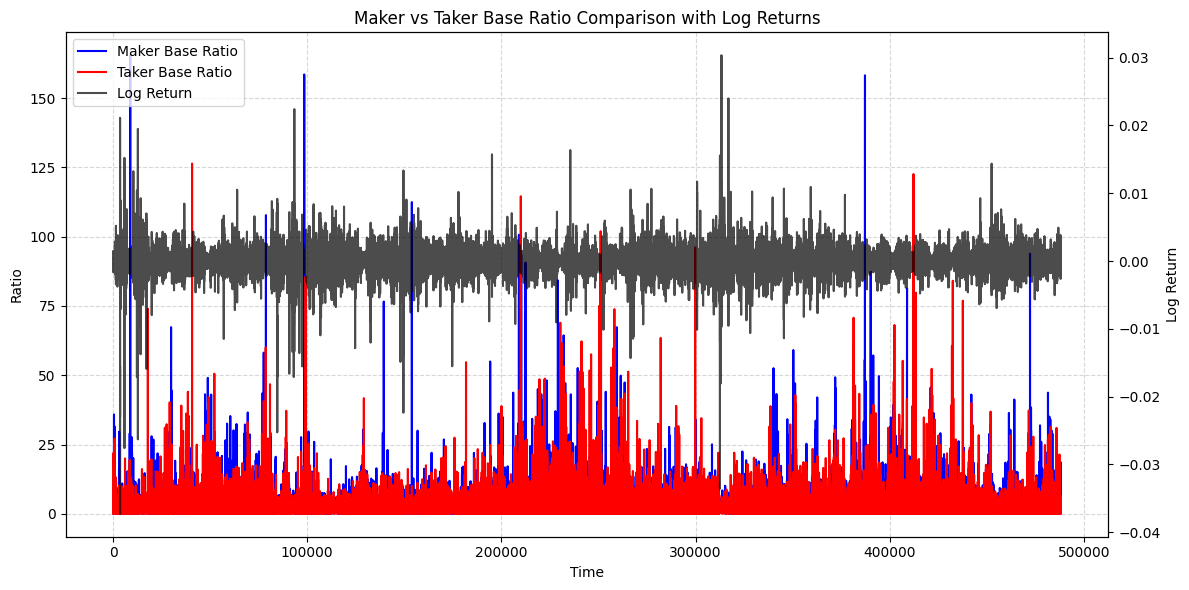

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_ratios(df):
    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Create a secondary y-axis
    ax2 = ax1.twinx()
    
    # Plot ratios on primary y-axis
    line1 = ax1.plot(df.index, df['maker_base_ratio'], label='Maker Base Ratio', color='blue')
    line2 = ax1.plot(df.index, df['taker_base_ratio'], label='Taker Base Ratio', color='red')
    
    # Plot log returns on secondary y-axis
    line3 = ax2.plot(df.index, df['log_return'], label='Log Return', color='black', alpha=0.7)
    
    # Customize the plot
    ax1.set_title('Maker vs Taker Base Ratio Comparison with Log Returns')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Ratio')
    ax2.set_ylabel('Log Return')
    
    # Add grid
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Combine legends from both axes
    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
# Call the function with your dataframe
plot_ratios(df)

# To save the plot
# plt.savefig('ratios_and_returns.png')

In [16]:
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

def analyze_predictive_power(df):
    # 1. Create lagged variables
    df['maker_ratio_lag1'] = df['maker_base_ratio'].shift(1)
    df['taker_ratio_lag1'] = df['taker_base_ratio'].shift(1)
    
    # 2. Drop NA values
    df_clean = df.dropna()
    
    # 3. Prepare data
    # Contemporaneous model
    X_contemp = sm.add_constant(df_clean[['maker_base_ratio', 'taker_base_ratio']])
    
    # Predictive model
    X_pred = sm.add_constant(df_clean[['maker_ratio_lag1', 'taker_ratio_lag1']])
    
    y = df_clean['log_return']
    
    # 4. Fit models
    # Contemporaneous model
    model_contemp = sm.OLS(y, X_contemp)
    results_contemp = model_contemp.fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    
    # Predictive model
    model_pred = sm.OLS(y, X_pred)
    results_pred = model_pred.fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    
    # 5. Run diagnostics
    # Breusch-Pagan test for heteroskedasticity
    bp_test_contemp = het_breuschpagan(results_contemp.resid, X_contemp)
    bp_test_pred = het_breuschpagan(results_pred.resid, X_pred)
    
    # Durbin-Watson test for autocorrelation
    dw_contemp = durbin_watson(results_contemp.resid)
    dw_pred = durbin_watson(results_pred.resid)
    
    print("=============================================")
    print("Contemporaneous Model Results:")
    print("=============================================")
    print(results_contemp.summary())
    print("\nDiagnostics:")
    print(f"Breusch-Pagan test p-value: {bp_test_contemp[1]}")
    print(f"Durbin-Watson statistic: {dw_contemp}")
    
    print("\n=============================================")
    print("Predictive Model Results (Using Lagged Ratios):")
    print("=============================================")
    print(results_pred.summary())
    print("\nDiagnostics:")
    print(f"Breusch-Pagan test p-value: {bp_test_pred[1]}")
    print(f"Durbin-Watson statistic: {dw_pred}")
    
    return results_contemp, results_pred

# Run the analysis
results_contemp, results_pred = analyze_predictive_power(df)

# Function to test multiple lags
def test_multiple_lags(df, max_lags=5):
    results_dict = {}
    
    for lag in range(1, max_lags + 1):
        # Create lagged variables
        df_lagged = df.copy()
        df_lagged['maker_ratio_lag'] = df_lagged['maker_base_ratio'].shift(lag)
        df_lagged['taker_ratio_lag'] = df_lagged['taker_base_ratio'].shift(lag)
        
        # Drop NA values
        df_lagged = df_lagged.dropna()
        
        # Prepare data
        X = sm.add_constant(df_lagged[['maker_ratio_lag', 'taker_ratio_lag']])
        y = df_lagged['log_return']
        
        # Fit model
        model = sm.OLS(y, X)
        results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 5})
        
        # Store results
        results_dict[lag] = {
            'r_squared': results.rsquared,
            'adj_r_squared': results.rsquared_adj,
            'aic': results.aic,
            'bic': results.bic,
            'f_pvalue': results.f_pvalue,
            'maker_pvalue': results.pvalues['maker_ratio_lag'],
            'taker_pvalue': results.pvalues['taker_ratio_lag']
        }
    
    return pd.DataFrame(results_dict).T

# Test different lag structures
lag_analysis = test_multiple_lags(df)
print("\nAnalysis of Different Lag Structures:")
print(lag_analysis.round(4))

Contemporaneous Model Results:
                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     1916.
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        07:30:36   Log-Likelihood:             2.8488e+06
No. Observations:              488134   AIC:                        -5.698e+06
Df Residuals:                  488131   BIC:                        -5.698e+06
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const    

Rolling Method 

In [11]:
import seaborn as sns 
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt


def rolling_combined_transform_no_lookahead(df, window=60, min_periods=60, lower=0.01, upper=0.99):
    """
    Apply rolling winsorization + log transform + standardization using only past data
    """
    winsorized_series = pd.Series(index=df.index, dtype=float)
    transformed_series = pd.Series(index=df.index, dtype=float)
    
    # Iterate through the data using only past information
    for i in range(len(df)):
        if i < min_periods: 
            # For initial period, just use the original value
            winsorized_series.iloc[i] = df['maker_base_ratio'].iloc[i]
            transformed_series.iloc[i] = df['maker_base_ratio'].iloc[i]
            continue
            
        # Use only past window data
        past_window = df['maker_base_ratio'].iloc[max(0, i-window):i]
        
        # Step 1: Winsorization
        lower_bound = past_window.quantile(lower)
        upper_bound = past_window.quantile(upper)
        current_value = df['maker_base_ratio'].iloc[i]
        winsorized_value = np.clip(current_value, lower_bound, upper_bound)
        winsorized_series.iloc[i] = winsorized_value
        
        # Step 2: Log transformation : np.log1p  = log(1+x)
        past_window_winsorized = winsorized_series.iloc[max(0, i-window):i]
        past_window_log = np.log1p(past_window_winsorized)
        
        # Step 3: Calculate standardization parameters from past data
        past_mean = past_window_log.mean()
        past_std = past_window_log.std()
        
        # Step 4: Apply combined transformation to --> current value
        # Log transform the winsorized value
        log_value = np.log1p(winsorized_value)
        
        # Standardize using past window statistics
        if past_std != 0:  # Avoid division by zero
            transformed_value = (log_value - past_mean) / past_std
        else:
            transformed_value = log_value - past_mean
            
        transformed_series.iloc[i] = transformed_value
    
    return winsorized_series, transformed_series

def analyze_transformations(df):   # print out statistic 
    """
    Apply transformations and analyze results
    """
    # Apply rolling transformations
    df['maker_base_ratio_winsorized'], df['maker_base_ratio_transformed'] = \
        rolling_combined_transform_no_lookahead(df)
    
    # Calculate additional metrics for comparison
    df['maker_base_ratio_log'] = np.log1p(df['maker_base_ratio'])
    df['maker_base_ratio_centered'] = df['maker_base_ratio'] - 1
    
    # Print statistics for each transformation
    transformations = [
        'maker_base_ratio', 
        'maker_base_ratio_winsorized',
        'maker_base_ratio_log', 
        'maker_base_ratio_transformed'
    ]
    
    print("\nStatistics for each transformation:")
    for col in transformations:
        print(f"\n{col}:")
        stats = {
            'mean': df[col].mean(),
            'std': df[col].std(),
            'skew': df[col].skew(),
            'kurtosis': df[col].kurtosis(),
            'min': df[col].min(),
            'max': df[col].max()
        }
        for name, value in stats.items():
            print(f"{name}: {value:.4f}")
    
    return df

def plot_transformations(df):  # plot only 
    """
    Plot the original and transformed series
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Transformations of Maker Base Ratio')

    # Original
    sns.histplot(df['maker_base_ratio'], bins=50, ax=axes[0,0])
    axes[0,0].set_title('Original')
    axes[0,0].axvline(x=1, color='r', linestyle='--', alpha=0.5)

    # Winsorized
    sns.histplot(df['maker_base_ratio_winsorized'], bins=50, ax=axes[0,1])
    axes[0,1].set_title('Rolling Winsorized')
    axes[0,1].axvline(x=1, color='r', linestyle='--', alpha=0.5)

    # Log transformed
    sns.histplot(df['maker_base_ratio_log'], bins=50, ax=axes[1,0])
    axes[1,0].set_title('Log Transformed')

    # Combined transformation
    sns.histplot(df['maker_base_ratio_transformed'], bins=50, ax=axes[1,1])
    axes[1,1].set_title('Combined Rolling Transform\n(Winsor + Log + Standardize)')

    plt.tight_layout()
    plt.show()



Results with transformed ratios:
                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     18.14
Date:                Wed, 12 Feb 2025   Prob (F-statistic):           1.33e-08
Time:                        08:24:56   Log-Likelihood:             2.8106e+06
No. Observations:              488134   AIC:                        -5.621e+06
Df Residuals:                  488131   BIC:                        -5.621e+06
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

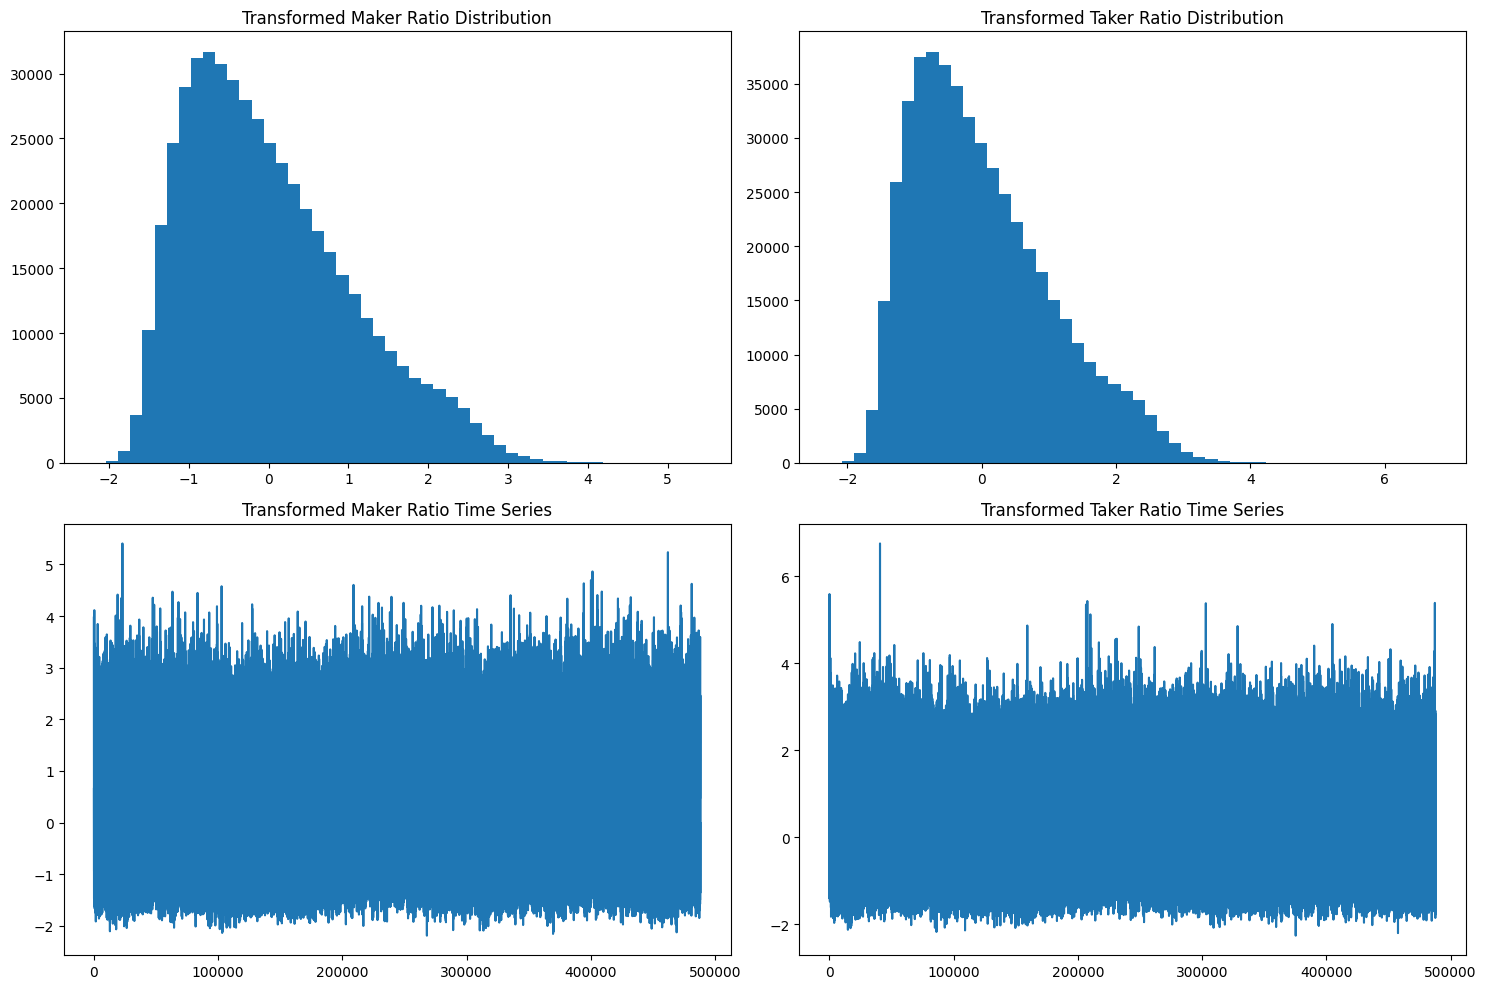

In [13]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
import seaborn as sns

def process_ratios(df, window=60, min_periods=60):
    """
    Process both maker and taker ratios using rolling transformations
    """
    # Process maker ratio
    maker_wins, maker_trans = rolling_combined_transform_no_lookahead(
        df, 
        window=window, 
        min_periods=min_periods,
        ratio_column='maker_base_ratio'
    )
    
    # Process taker ratio
    taker_wins, taker_trans = rolling_combined_transform_no_lookahead(
        df, 
        window=window, 
        min_periods=min_periods,
        ratio_column='taker_base_ratio'
    )
    
    # Add transformed series to dataframe
    df['maker_ratio_transformed'] = maker_trans
    df['taker_ratio_transformed'] = taker_trans
    
    return df

def rolling_combined_transform_no_lookahead(df, window=60, min_periods=60, lower=0.01, upper=0.99, ratio_column='maker_base_ratio'):
    """
    Apply rolling winsorization + log transform + standardization using only past data
    """
    winsorized_series = pd.Series(index=df.index, dtype=float)
    transformed_series = pd.Series(index=df.index, dtype=float)
    
    for i in range(len(df)):
        if i < min_periods:
            winsorized_series.iloc[i] = df[ratio_column].iloc[i]
            transformed_series.iloc[i] = df[ratio_column].iloc[i]
            continue
            
        past_window = df[ratio_column].iloc[max(0, i-window):i]
        
        # Winsorization
        lower_bound = past_window.quantile(lower)
        upper_bound = past_window.quantile(upper)
        current_value = df[ratio_column].iloc[i]
        winsorized_value = np.clip(current_value, lower_bound, upper_bound)
        winsorized_series.iloc[i] = winsorized_value
        
        # Log transformation
        past_window_winsorized = winsorized_series.iloc[max(0, i-window):i]
        past_window_log = np.log1p(past_window_winsorized)
        
        # Standardization
        past_mean = past_window_log.mean()
        past_std = past_window_log.std()
        
        log_value = np.log1p(winsorized_value)
        
        if past_std > 1e-8:  # Added threshold
            transformed_value = (log_value - past_mean) / past_std
        else:
            transformed_value = log_value - past_mean
            
        transformed_series.iloc[i] = transformed_value
    
    return winsorized_series, transformed_series

def analyze_with_transformed_ratios(df):
    # First process the ratios
    df = process_ratios(df)
    
    # Create lagged versions of transformed ratios
    df['maker_ratio_transformed_lag1'] = df['maker_ratio_transformed'].shift(1)
    df['taker_ratio_transformed_lag1'] = df['taker_ratio_transformed'].shift(1)
    
    # Drop the initial window period and any NaN values
    df_clean = df.dropna()
    
    # Prepare data for regression
    X = sm.add_constant(df_clean[['maker_ratio_transformed_lag1', 'taker_ratio_transformed_lag1']])
    y = df_clean['log_return']
    
    # Fit model
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    
    # Run diagnostics
    bp_test = het_breuschpagan(results.resid, X)
    dw_stat = durbin_watson(results.resid)
    
    print("Results with transformed ratios:")
    print(results.summary())
    print("\nDiagnostics:")
    print(f"Breusch-Pagan test p-value: {bp_test[1]}")
    print(f"Durbin-Watson statistic: {dw_stat}")
    
    return results

# Run the analysis
results_transformed = analyze_with_transformed_ratios(df)

# Optional: Plot the transformed series
def plot_transformed_ratios(df):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2,2,1)
    plt.hist(df['maker_ratio_transformed'], bins=50)
    plt.title('Transformed Maker Ratio Distribution')
    
    plt.subplot(2,2,2)
    plt.hist(df['taker_ratio_transformed'], bins=50)
    plt.title('Transformed Taker Ratio Distribution')
    
    plt.subplot(2,2,3)
    plt.plot(df['maker_ratio_transformed'])
    plt.title('Transformed Maker Ratio Time Series')
    
    plt.subplot(2,2,4)
    plt.plot(df['taker_ratio_transformed'])
    plt.title('Transformed Taker Ratio Time Series')
    
    plt.tight_layout()
    plt.show()

# Plot the transformations
plot_transformed_ratios(df)